In [35]:
from torch.utils.data import DataLoader, Dataset

from lightning import LightningDataModule

from src.data.components.data import FuturePredictionDataset
from omegaconf import DictConfig

In [36]:
from omegaconf import OmegaConf

common = OmegaConf.create({
    'semantic_segmentation': {
        'weights': [1.0, 2.0],
        'use_top_k': True,
        'top_k_ratio': 0.25,
    },
    'receptive_field': 3,
    'future_discount': 0.95,
    'ignore_index': 255,
    'lift': {
        'x_bound': [-50.0, 50.0, 0.5],
        'y_bound': [-50.0, 50.0, 0.5],
        'z_bound': [-10.0, 10.0, 20.0],
        'd_bound': [2.0, 50.0, 1.0],
    },
    'image': {
        'final_dim': [224, 480],
        'resize_scale': 0.3,
        'top_crop': 46,
        'original_height': 900,
        'original_width': 1600,
        'names': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'],
    },
})



In [37]:
import os

data_root = '/home/slabban/machine_learning/projects/bev-hydra/data/nuscenes'
version = 'trainval'
batch_size = 1
filter_invisible_vehicles = True
num_workers = 4
pin_memory = True


Create Dataset

In [38]:
data_train = FuturePredictionDataset(
            data_root=data_root, is_train=True, version=version, batch_size=batch_size, filter_invisible_vehicles=filter_invisible_vehicles, common=common
        )

Create DataLoader

In [39]:
data_loader = DataLoader(
            dataset=data_train,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            shuffle=True, drop_last= True
        )

Get first batch

In [40]:
sample = next(iter(data_loader))

In [41]:
print(sample.keys())

dict_keys(['image', 'intrinsics', 'extrinsics', 'segmentation', 'instance', 'centerness', 'offset', 'flow', 'future_egomotion', 'sample_token', 'z_position', 'attribute'])


_input_: We see the the model inputs, which is a sequence of croppped images, along with their intrinsics, extrinsics, and the translation of ego motion from one frame to the next.
In this case, the input will only be the past 2 frames along with the current frame that will be compared for predictions.

_output labels_: Birds Eye View consisting of segmentation. instances, centerness, offset (from center), future flow (we wont be using this) 

In [42]:
import torch
for key in sample.keys():
    if isinstance(sample[key], torch.Tensor):
        print(key, sample[key].shape)

image torch.Size([1, 3, 6, 3, 224, 480])
intrinsics torch.Size([1, 3, 6, 3, 3])
extrinsics torch.Size([1, 3, 6, 4, 4])
segmentation torch.Size([1, 3, 1, 200, 200])
instance torch.Size([1, 3, 200, 200])
centerness torch.Size([1, 3, 1, 200, 200])
offset torch.Size([1, 3, 2, 200, 200])
flow torch.Size([1, 3, 2, 200, 200])
future_egomotion torch.Size([1, 3, 6])
z_position torch.Size([1, 3, 1, 200, 200])
attribute torch.Size([1, 3, 1, 200, 200])


In [47]:
from src.utils.visualisation import plot_instance_map, make_contour, heatmap_image, flow_to_image

In [48]:
output_label_list = ['segmentation', 'instance', 'offset', 'centerness']

output_labels = {label: sample[label] for label in output_label_list}

In [69]:
import numpy as np
def visualise_labels(labels, sequence_length):
    semantic_colours = np.array([[255, 255, 255], [0, 0, 0]], dtype=np.uint8)

    b = 0
    video = []
    for t in range(sequence_length):
        out_t = []
        # Ground truth
        unique_ids = torch.unique(labels['instance'][b, t]).cpu().numpy()[1:]
        instance_map = dict(zip(unique_ids, unique_ids))
        instance_plot = plot_instance_map(labels['instance'][b, t].cpu(), instance_map)[::-1, ::-1]
        instance_plot = make_contour(instance_plot)

        semantic_seg = labels['segmentation'].squeeze(2).cpu().numpy()
        semantic_plot = semantic_colours[semantic_seg[b, t][::-1, ::-1]]
        semantic_plot = make_contour(semantic_plot)

        future_flow_plot = np.zeros_like(semantic_plot)

        center_plot = heatmap_image(labels['centerness'][b, t, 0].cpu().numpy())[::-1, ::-1]
        center_plot = make_contour(center_plot)

        offset_plot = labels['offset'][b, t].cpu().numpy()
        offset_plot[:, semantic_seg[b, t] != 1] = 0
        offset_plot = flow_to_image(offset_plot)[::-1, ::-1]
        offset_plot = make_contour(offset_plot)

        out_t.append(np.concatenate([instance_plot, future_flow_plot,
                                     semantic_plot, center_plot, offset_plot], axis=0))

        video.append(out_t)

    # Shape (B, T, C, H, W)
    video = np.stack(video)[None]

    
    return video

In [70]:
sequence_length = output_labels['instance'].shape[1]
video = visualise_labels(output_labels, sequence_length)

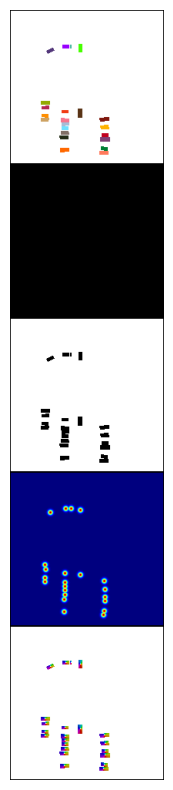

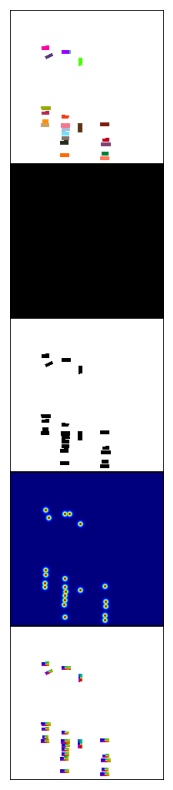

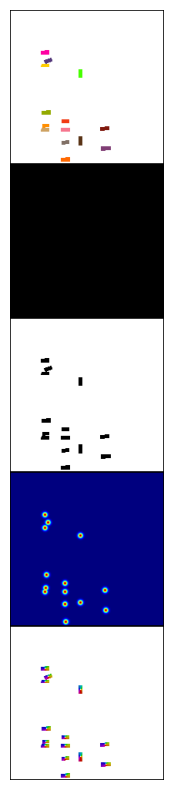

In [75]:
for frame in video[0]:
    plt.figure(figsize=(10, 10))
    plt.imshow(frame[0])
    plt.axis('off')
    plt.show()